In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import sys
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
device = "cpu"

### Data import

In [2]:
batch_size = 64

def normalization(x):
    return x*2-1

def back_img(x):
    y = (x+1)/2
    y = (y-y.min())/(2*y.abs().max())
    y = y.permute(1,2,0)
    return y

data_transforms = [
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Scales data into [0,1] 
    transforms.Lambda(normalization) # Scale between [-1, 1] 
]
data_transform = transforms.Compose(data_transforms)

In [3]:
name = 'FMNIST'

if name=='MNIST':
    df = pd.read_csv('/Users/alessandrobreccia/data/MNIST/mnist_train.csv')
    df = df.drop('label', axis = 1)
    df = df.sample(n=10000, random_state=42).reset_index(drop=True)
    data = torch.tensor(df.values)/255.0*2 - 1
    data = data.view(-1, 1, 28, 28).to(device)
    data = F.pad(data, (2, 2, 2, 2), mode='constant', value=-1)

if name=='FMNIST':
    df = pd.read_csv('/Users/alessandrobreccia/data/FMNIST/fashion-mnist_train.csv')
    df = df.drop('label', axis = 1)
    df = df.sample(n=10000, random_state=42).reset_index(drop=True)
    data = torch.tensor(df.values)/255.0*2 - 1
    data = data.view(-1, 1, 28, 28).to(device)
    data = F.pad(data, (2, 2, 2, 2), mode='constant', value=-1)

if name=='STCARS':
    dataset_path = "~/data/STANCARS/archive/cars_train"

    data = datasets.ImageFolder(root=dataset_path, transform=data_transform)
    

dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=0)
    

In [4]:
IS = next(iter(dataloader))[0].shape[-1]
f_out_ch = next(iter(dataloader))[0].shape[-3]

In [5]:
print(f_out_ch)

1


In [6]:
def plot_img(X,t):
    plt.figure(figsize = (16, 6))
    for i in range(len(t)):
        plt.subplot(1, len(t), i+1)
        img = next(iter(dataloader))[0]
        plt.imshow(back_img(img), cmap = 'gray')
        plt.axis('off')
    plt.show()

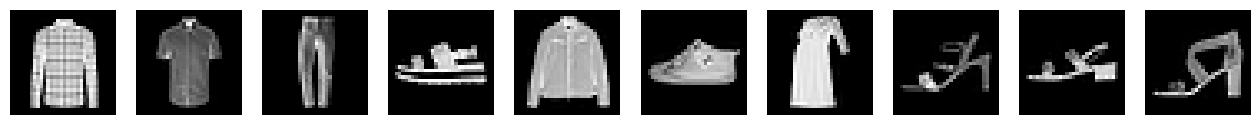

In [7]:
plot_img(data, torch.randint(0, 100, (10,)))

In [8]:
T = 300
cosine_sched = True

def cos_sched(t, eps = 1E-6):
    return torch.cos( (t/T+eps)/(1+eps)*torch.pi/2 )**2

if not cosine_sched:
    b = torch.linspace(0.00001,0.04,T).to(device)
    a = 1.0 - b
    a_bar = a.cumprod(dim=0).to(device)
    a_prev = F.pad(a_bar[:-1], (1, 0), value=1.0)
    var = b*(1-a_prev)/(1-a_bar)
else:
    t_lin = torch.linspace(0,T-1,T).to(device)
    a_bar = cos_sched(t_lin)/cos_sched(torch.tensor([0])) - 1E-5
    a_prev = F.pad(a_bar[:-1], (1, 0), value=1.0)
    b = 1 - a_bar/a_prev
    a = 1.0 - b
    var = b*(1-a_prev)/(1-a_bar)

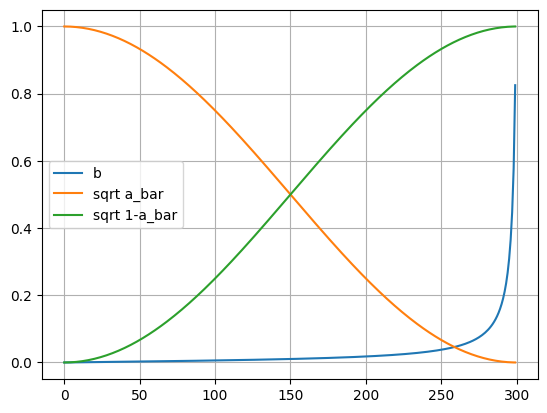

tensor(0.0042) tensor(1.0000)


In [9]:
plt.plot(b.cpu(), label = 'b')
#plt.plot(a.cpu(), label = 'a')
plt.plot(a_bar.cpu(), label = 'sqrt a_bar')
plt.plot((1-a_bar.cpu()), label = 'sqrt 1-a_bar')
plt.grid()
plt.legend()
plt.show()
print(a_bar[-1]**0.5, (1-a_bar[-1])**0.5)

In [10]:
def noisy_img(X, t):
    noise = torch.randn_like(X)
    a_bar_t = a_bar[t].view(-1, 1, 1, 1)
    x_noise = a_bar_t**0.5*X + (1-a_bar_t)**0.5*noise
    return  x_noise, noise

In [11]:
def plot_noise_schedule(X):
    plt.figure(figsize = (16, 6))
    for i,t in enumerate(torch.linspace(0,T-1,10)):
        plt.subplot(1, 10, i+1)
        x, _ = noisy_img(X,int(t))
        plt.imshow(back_img(x).cpu(), cmap='gray')
        plt.title(f't = {int(t)}')
        plt.axis('off')
    plt.show()

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

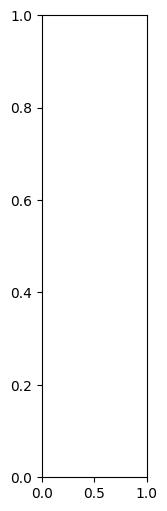

In [12]:
plot_noise_schedule( next(iter(dataloader))[torch.randint(batch_size,(1,))] )

### Denoising Model

In [13]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        embeddings = math.log(self.dim*2) / (self.dim - 1)
        embeddings = torch.exp(torch.arange(half_dim) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
    
class UBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()

        self.time = TimeEmbedding(time_emb_dim).to(device)
        self.time_emb = nn.Linear(time_emb_dim, out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x, t):
        # Time embedding 
        time = self.time(t.float())
        # Activation after projection
        time = self.relu(self.time_emb(time))
        # Adjust time embedding to the same shape as x
        time = time.unsqueeze(-1).unsqueeze(-1)
        # first convolution
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batchnorm(x)
        # Add time embedding
        x = x + time
        # Second convolution
        x = self.conv2(x)
        x = self.relu(x)
        x = self.batchnorm(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_dim = 128
        self.channels = [f_out_ch, 32, 64, 128, 256, 512]

        self.pool = nn.MaxPool2d(2)

        self.down_blocks = nn.ModuleList([UBlock(self.channels[i-1], self.channels[i], self.emb_dim) for i in range(1, len(self.channels))])
        self.up_blocks = nn.ModuleList([UBlock(self.channels[i], self.channels[i-1], self.emb_dim) for i in range(len(self.channels)-1, 1, -1)])
        self.out = nn.Conv2d(self.channels[1], f_out_ch, 1)
        self.convT = [nn.ConvTranspose2d(self.channels[i], self.channels[i-1], 2, stride=2) for i in range(len(self.channels)-1, 1, -1)]

    def forward(self, x, t):
        downs = []
        for i in range(0, len(self.down_blocks)):
            x = self.down_blocks[i](x, t)
            downs.append(x)
            if i != len(self.down_blocks)-1:
                x = self.pool(x)

        for i in range(len(self.up_blocks)):
            x = self.convT[i](x)
            x = torch.cat((x, downs[len(downs)-i-2]), dim = 1)
            x = self.up_blocks[i](x, t)

        out = self.out(x)
        return out
  

In [14]:
model = UNet()
model_params = sum(p.numel() for p in model.parameters())
print("Model's params:", model_params)
model

Model's params: 7255553


UNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_blocks): ModuleList(
    (0): UBlock(
      (time): TimeEmbedding()
      (time_emb): Linear(in_features=128, out_features=32, bias=True)
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): UBlock(
      (time): TimeEmbedding()
      (time_emb): Linear(in_features=128, out_features=64, bias=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): UBlock(
      (time): TimeEmbedding()
      (time_emb): Linear

In [15]:
mus = []
@torch.no_grad()
def sample_at_time(model, x, t):

    cov = b[t]/(1-a_bar[t])**0.5
    noise = model(x, t)
    
    mu = 1/a[t]**0.5*(x-cov*noise)
    mus.append(mu.mean())

    if t == 0:
        return mu
    else:
        return mu + torch.randn_like(noise)*b[t]**0.5

@torch.no_grad()
def sample(model, w=16, h=5, histo=False):

    img_shape = (1,f_out_ch,IS,IS)
    img = torch.randn(img_shape)

    times = [290,250,200,150,100,50,25,12,0]
    fig = plt.figure(figsize=(w,h))
    j = 1

    for i in range(0,T)[::-1]:
        t = torch.tensor([i])
        img = sample_at_time(model, img, t)
        img = img/img.max()
        #img = torch.clamp(img, -1.0, 1.0)

        if i in times:
            if histo:
                plt.subplot(1, len(times), j)
                plt.title(f' m = {img.view(-1).mean():03f}')
                #plt.axis('off')
                counts, bins = torch.histogram(img.view(-1))
                plt.hist(bins[:-1], bins, weights=counts, density=True)
                plt.grid()
            else:
                plt.subplot(1, len(times), j)
                plt.title(f't = {int(t.item())}')
                plt.axis('off')
                plt.imshow(back_img(img), cmap='gray')
            j += 1
    
    plt.show()
    

In [16]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

loss_hist = []
#device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
model = UNet()
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
#scheduler = ExponentialLR(optimizer, gamma=0.7)
iters = len(data) // batch_size
epochs = 100 
MSE = nn.MSELoss()

for epoch in range(epochs):
    for i, (x,y) in enumerate(dataloader):
      optimizer.zero_grad()

      #batch = data[i*batch_size:(i+1)*batch_size].to(device)
      t = torch.randint(0, T, (batch_size, ), device=device)

      x_noise, noise = noisy_img(x, t)
      noise_pred = model(x_noise, t)

      loss = MSE(noise, noise_pred)
      loss_hist.append(loss.detach().clone())
      loss.backward()
      optimizer.step()

      if i % int(iters/3) == 0:
        #scheduler.step()
        print(f"Epoch {epoch} | step {i:03d} Loss: {loss.item()} ")
        sample(model)

ValueError: too many values to unpack (expected 2)

In [ ]:
plt.plot(loss_hist)
plt.yscale('log')

In [ ]:
mus = []
sample(model)
plt.plot(mus)